### Introduction

The code consists of training and test process on epochs 30 with combination of learning rates {1e-3, 1e-4, 1e-5} and batch size {32, 64}. The results of two-stage architecture are based on respective best three models under 30 epochs. The final two-stage architecture results please refer to the 'Evaluation' code. 



In [4]:
###   EXP 1: one stage classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "HC": 3,
    "Laryngitis": 4,
    "Parkinson": 5,
    "Rekurrensparese": 6
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Validation MCC
def save_metrics(metrics, fold):
    metrics_df = pd.DataFrame(metrics, columns=["Epoch", "MCC"])
    metrics_df.to_csv(os.path.join(output_dir, f"validation_metrics_fold_{fold}.csv"), index=False)

# Test Set Evaluation
def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_matrix_fold_{fold}.png"))
    plt.close()

    # Test Set index
    mcc = matthews_corrcoef(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    test_results_path = os.path.join(output_dir, "test_metrics.csv")
    if not os.path.exists(test_results_path):
        with open(test_results_path, "w") as f:
            f.write("Fold,MCC,Precision,Recall,F1\n")
    with open(test_results_path, "a") as f:
        f.write(f"{fold},{mcc:.4f},{precision:.4f},{recall:.4f},{f1:.4f}\n")

### Training
for batch_size, lr in itertools.product([32, 64], [1e-3, 1e-4, 1e-5]):
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = np.mean(fold_metrics)
    std_mcc = np.std(fold_metrics)
    print(f"Cross-Validation Results for batch_size={batch_size}, lr={lr}: Avg MCC={avg_mcc:.4f}, Std MCC={std_mcc:.4f}")
    cv_results.append((batch_size, lr, avg_mcc, std_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

cv_results_df = pd.DataFrame(cv_results, columns=["Batch Size", "Learning Rate", "Avg MCC", "Std MCC"])
cv_results_df.to_csv(os.path.join(output_dir, "cv_results.csv"), index=False)
print(cv_results_df)


print(f"Best Parameters Found: Batch Size={best_params[0]}, Learning Rate={best_params[1]}, Avg MCC={best_val_mcc:.4f}")
# Retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Epoch 1: Train Loss: 0.7742, Validation Loss: 0.6578
Epoch 2: Train Loss: 0.6005, Validation Loss: 0.5991
Epoch 3: Train Loss: 0.5009, Validation Loss: 0.5135
Epoch 4: Train Loss: 0.4429, Validation Loss: 0.4246
Epoch 5: Train Loss: 0.3745, Validation Loss: 0.4814
Epoch 6: Train Loss: 0.3451, Validation Loss: 0.4101
Epoch 7: Train Loss: 0.3057, Validation Loss: 0.3745
Epoch 8: Train Loss: 0.2613, Validation Loss: 0.3758
Epoch 9: Train Loss: 0.2136, Validation Loss: 0.3756
Epoch 10: Train Loss: 0.1827, Validation Loss: 0.2900
Epoch 11: Train Loss: 0.1606, Validation Loss: 0.4153
Epoch 12: Train Loss: 0.1359, Validation Loss: 0.3705
Epoch 13: Train Loss: 0.1284, Validation Loss: 0.3326
Epoch 14: Train Loss: 0.1151, Validation Loss: 0.2539
Epoch 15: Train Loss: 0.0862, Validation Loss: 0.3733
Epoch 16: Train Loss: 0.0771, Validation Loss: 0.2755
Epoch 17: Train Loss: 0.0658, Validation Loss: 0.3775
Epoch 18: Train Loss: 0.0673, Validation Loss: 0.4117
Epoch 19: Train Loss: 0.0903, Validat

In [ ]:
### EXP 2: two stage architecture classifier

In [ ]:
### classifier PD training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "MC": 0,  # Male Control
    "MP": 1,  # Male Pathology
    "FC": 2,  # Female Control
    "FP": 3   # Female Pathology
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2: 
            mel = mel.unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=4):  
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1

    last_mcc_values = []  

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        last_mcc = matthews_corrcoef(y_true, y_pred)
        last_mcc_values.append(last_mcc)
        print(f"Fold {fold} | MCC: {last_mcc:.4f}")
        fold += 1

    avg_mcc = np.mean(last_mcc_values)
    print(f"Average MCC for batch_size={batch_size}, lr={lr}: {avg_mcc:.4f}")

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best Parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# Retrain on whole training set
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

train_losses = []

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    train_losses.append(avg_train_loss)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

final_model_save_path = os.path.join(output_dir, "final_group_classifier.pth")
torch.save(final_model.state_dict(), final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

final_model.load_state_dict(torch.load(final_model_save_path))
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch 1: Train Loss: 0.7511, Validation Loss: 0.7173
Epoch 2: Train Loss: 0.5838, Validation Loss: 0.5420
Epoch 3: Train Loss: 0.4954, Validation Loss: 0.7836
Epoch 4: Train Loss: 0.4233, Validation Loss: 0.5150
Epoch 5: Train Loss: 0.3557, Validation Loss: 0.4623
Epoch 6: Train Loss: 0.3037, Validation Loss: 0.3629
Epoch 7: Train Loss: 0.2578, Validation Loss: 0.3498
Epoch 8: Train Loss: 0.2062, Validation Loss: 0.3594
Epoch 9: Train Loss: 0.1783, Validation Loss: 0.2798
Epoch 10: Train Loss: 0.1597, Validation Loss: 0.3240
Epoch 11: Train Loss: 0.1291, Validation Loss: 0.3151
Epoch 12: Train Loss: 0.1100, Validation Loss: 0.3154
Epoch 13: Train Loss: 0.1103, Validation Loss: 0.3605
Epoch 14: Train Loss: 0.0805, Validation Loss: 0.2202
Epoch 15: Train Loss: 0.0877, Validation Loss: 0.5518
Epoch 16: Train Loss: 0.0853, Validation Loss: 0.2827
Epoch 17: Train Loss: 0.0503, Validation Loss: 0.2868
Epoch 18: Train Loss: 0.0669, Validation Loss: 0.3022
Epoch 19: Train Loss: 0.0795, Validat

<ipython-input-3-78d3d808d163>:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(final_model_save_path))


Test Set Results - Fold Final: MCC: 0.9522


In [ ]:
## classifier PD test

<ipython-input-4-99cc715392d4>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))


Precision: 0.9672
Recall: 0.9671
F1 Score: 0.9671
MCC: 0.9522


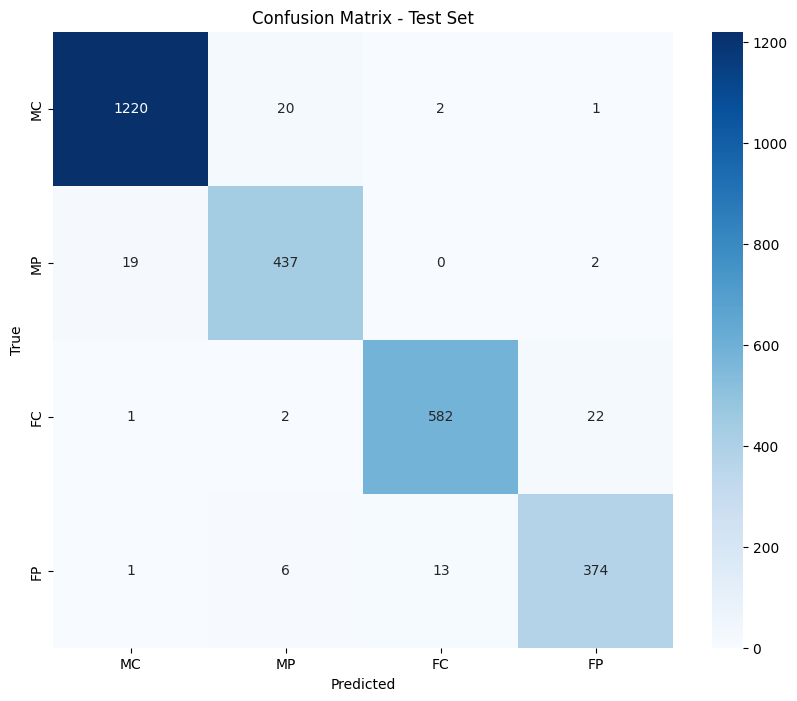

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)


In [ ]:
### classifier MP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_MP_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# Retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_MP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 1748
Filtered testing samples: 458
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001
Epoch 1: Train Loss: 0.6190, Validation Loss: 1.0154
Epoch 2: Train Loss: 0.3675, Validation Loss: 0.4010
Epoch 3: Train Loss: 0.3330, Validation Loss: 0.3903
Epoch 4: Train Loss: 0.3809, Validation Loss: 0.4140
Epoch 5: Train Loss: 0.2868, Validation Loss: 0.3138
Epoch 6: Train Loss: 0.2654, Validation Loss: 0.3767
Epoch 7: Train Loss: 0.2118, Validation Loss: 0.3345
Epoch 8: Train Loss: 0.2140, Validation Loss: 0.2537
Epoch 9: Train Loss: 0.2043, Validation Loss: 0.2907
Epoch 10: Train Loss: 0.1508, Validation Loss: 0.4128
Epoch 11: Train Loss: 0.1423, Validation Loss: 0.2906
Epoch 12: Train Loss: 0.0830, Validation Loss: 0.2747
Epoch 13: Train Loss: 0.1328, Validation Loss: 0.3435
Epoch 14: Train Loss: 0

In [ ]:
### classifier MP test

<ipython-input-6-5a625e53b0fb>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))


Precision: 0.9913
Recall: 0.9913
F1 Score: 0.9912
MCC: 0.9863


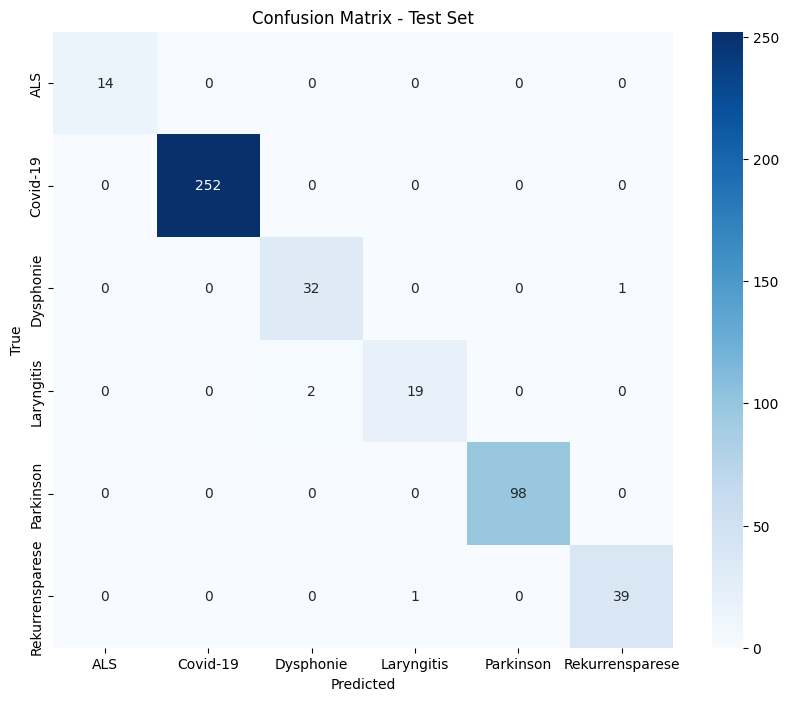

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
## classifier FP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path 

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2: 
            mel = mel.unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_FP_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_FP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 1659
Filtered testing samples: 394
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001
Epoch 1: Train Loss: 0.6344, Validation Loss: 0.6319
Epoch 2: Train Loss: 0.4215, Validation Loss: 0.4423
Epoch 3: Train Loss: 0.3689, Validation Loss: 0.3533
Epoch 4: Train Loss: 0.3059, Validation Loss: 0.4669
Epoch 5: Train Loss: 0.3448, Validation Loss: 0.4635
Epoch 6: Train Loss: 0.2943, Validation Loss: 0.2983
Epoch 7: Train Loss: 0.2457, Validation Loss: 1.3133
Epoch 8: Train Loss: 0.2336, Validation Loss: 0.3490
Epoch 9: Train Loss: 0.2214, Validation Loss: 0.4369
Epoch 10: Train Loss: 0.1404, Validation Loss: 0.4419
Epoch 11: Train Loss: 0.2244, Validation Loss: 0.3551
Epoch 12: Train Loss: 0.2042, Validation Loss: 0.4367
Epoch 13: Train Loss: 0.1081, Validation Loss: 0.2687
Epoch 14: Train Loss: 0

In [ ]:
### classifier FP test

<ipython-input-8-193dd2f226d0>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))


Precision: 0.9676
Recall: 0.9670
F1 Score: 0.9671
MCC: 0.9560


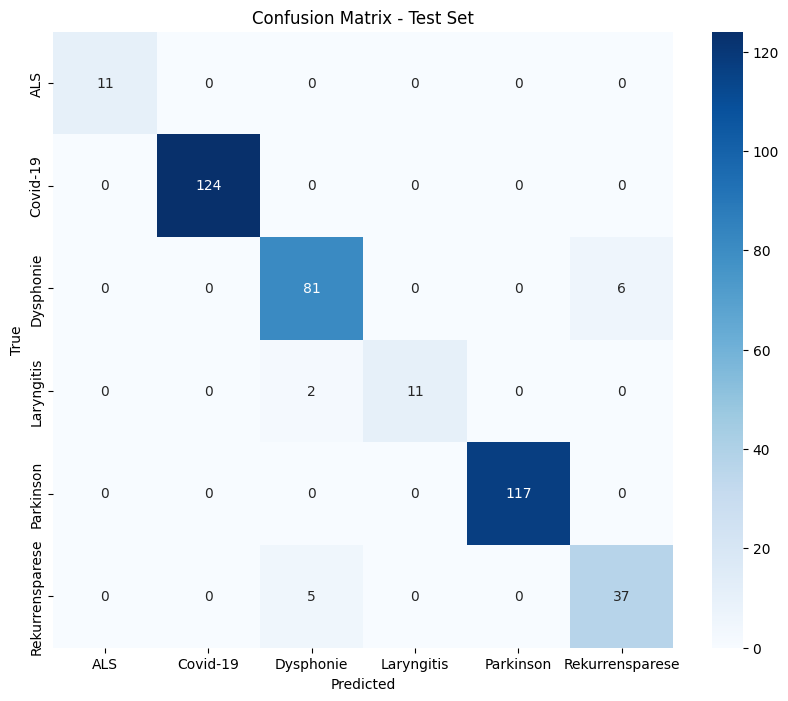

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
### two stage architecture test

Using device: cuda
Total samples: 2702
Samples classified as HC: 1838
Precision: 0.9678
Recall: 0.9674
F1 Score: 0.9675
MCC: 0.9356


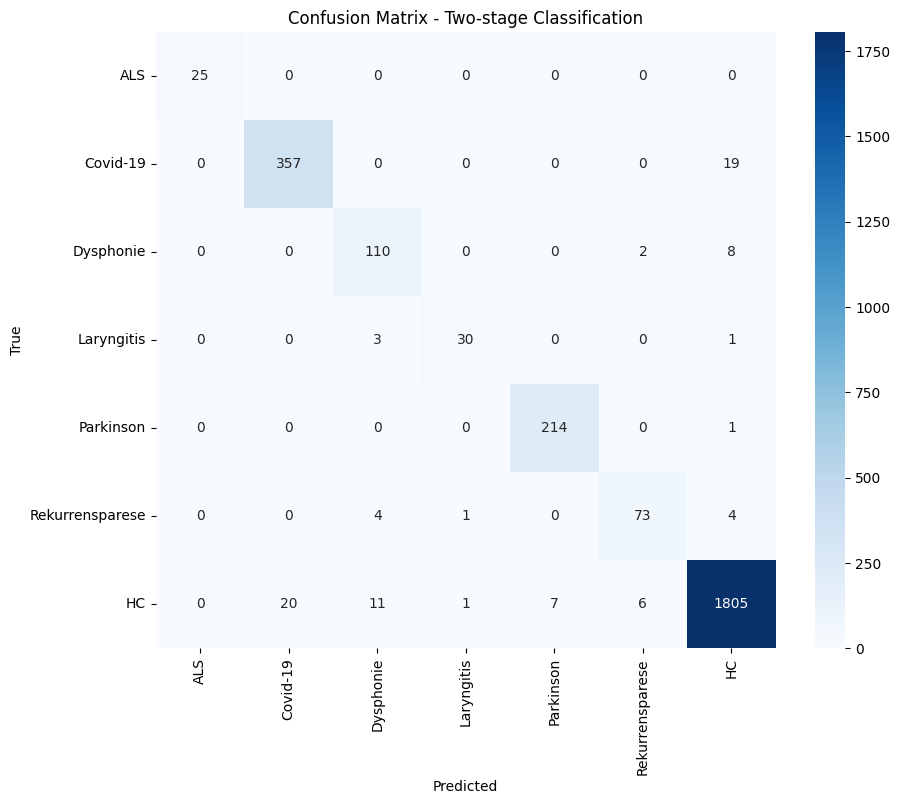

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5:  
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()


In [ ]:
### EXP 3.1 Resampling Augmentation based two stage architecture

In [ ]:
### classifier PD training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "MC": 0,  # Male Control
    "MP": 1,  # Male Pathology
    "FC": 2,  # Female Control
    "FP": 3   # Female Pathology
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=4):  
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1

    last_mcc_values = []  

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        last_mcc = matthews_corrcoef(y_true, y_pred)
        last_mcc_values.append(last_mcc)
        print(f"Fold {fold} | MCC: {last_mcc:.4f}")
        fold += 1

    avg_mcc = np.mean(last_mcc_values)
    print(f"Average MCC for batch_size={batch_size}, lr={lr}: {avg_mcc:.4f}")

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best Parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# Retrain on whole training set
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

train_losses = []

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    train_losses.append(avg_train_loss)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

final_model_save_path = os.path.join(output_dir, "final_group_classifier.pth")
torch.save(final_model.state_dict(), final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

final_model.load_state_dict(torch.load(final_model_save_path))
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


Epoch 1: Train Loss: 0.7621, Validation Loss: 0.5780
Epoch 2: Train Loss: 0.5970, Validation Loss: 0.6537
Epoch 3: Train Loss: 0.5085, Validation Loss: 0.5248
Epoch 4: Train Loss: 0.4150, Validation Loss: 0.5403
Epoch 5: Train Loss: 0.3538, Validation Loss: 0.3854
Epoch 6: Train Loss: 0.2868, Validation Loss: 0.4154
Epoch 7: Train Loss: 0.2502, Validation Loss: 0.3497
Epoch 8: Train Loss: 0.2193, Validation Loss: 0.3465
Epoch 9: Train Loss: 0.1895, Validation Loss: 0.3675
Epoch 10: Train Loss: 0.1486, Validation Loss: 0.3378
Epoch 11: Train Loss: 0.1239, Validation Loss: 0.2719
Epoch 12: Train Loss: 0.1172, Validation Loss: 0.3261
Epoch 13: Train Loss: 0.1077, Validation Loss: 0.2484
Epoch 14: Train Loss: 0.0973, Validation Loss: 0.2628
Epoch 15: Train Loss: 0.1303, Validation Loss: 0.2808
Epoch 16: Train Loss: 0.0530, Validation Loss: 0.3234
Epoch 17: Train Loss: 0.0534, Validation Loss: 0.2960
Epoch 18: Train Loss: 0.0732, Validation Loss: 0.3203
Epoch 19: Train Loss: 0.0555, Validat

<ipython-input-2-78d3d808d163>:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(final_model_save_path))


Test Set Results - Fold Final: MCC: 0.9435


In [ ]:
## classifier PD test

<ipython-input-3-99cc715392d4>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))


Precision: 0.9615
Recall: 0.9611
F1 Score: 0.9610
MCC: 0.9435


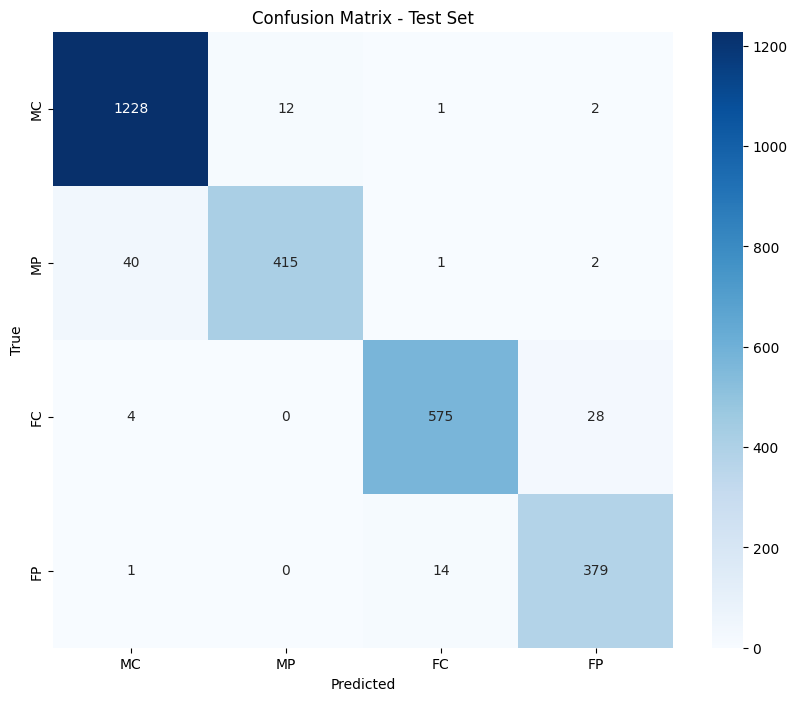

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)


In [ ]:
### classifier MP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path 

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# Retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_MP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 5589
Filtered testing samples: 458
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001
Epoch 1: Train Loss: 0.6363, Validation Loss: 0.3889
Epoch 2: Train Loss: 0.3706, Validation Loss: 0.3473
Epoch 3: Train Loss: 0.2086, Validation Loss: 0.2186
Epoch 4: Train Loss: 0.1862, Validation Loss: 0.1506
Epoch 5: Train Loss: 0.1188, Validation Loss: 0.1249
Epoch 6: Train Loss: 0.1121, Validation Loss: 0.1289
Epoch 7: Train Loss: 0.0774, Validation Loss: 0.2324
Epoch 8: Train Loss: 0.0411, Validation Loss: 0.0958
Epoch 9: Train Loss: 0.0444, Validation Loss: 0.0835
Epoch 10: Train Loss: 0.0502, Validation Loss: 0.1786
Epoch 11: Train Loss: 0.0639, Validation Loss: 0.0603
Epoch 12: Train Loss: 0.0186, Validation Loss: 0.0434
Epoch 13: Train Loss: 0.0295, Validation Loss: 0.1091
Epoch 14: Train Loss: 0

In [ ]:
### classifier MP test

<ipython-input-5-5a625e53b0fb>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))


Precision: 0.9868
Recall: 0.9869
F1 Score: 0.9868
MCC: 0.9794


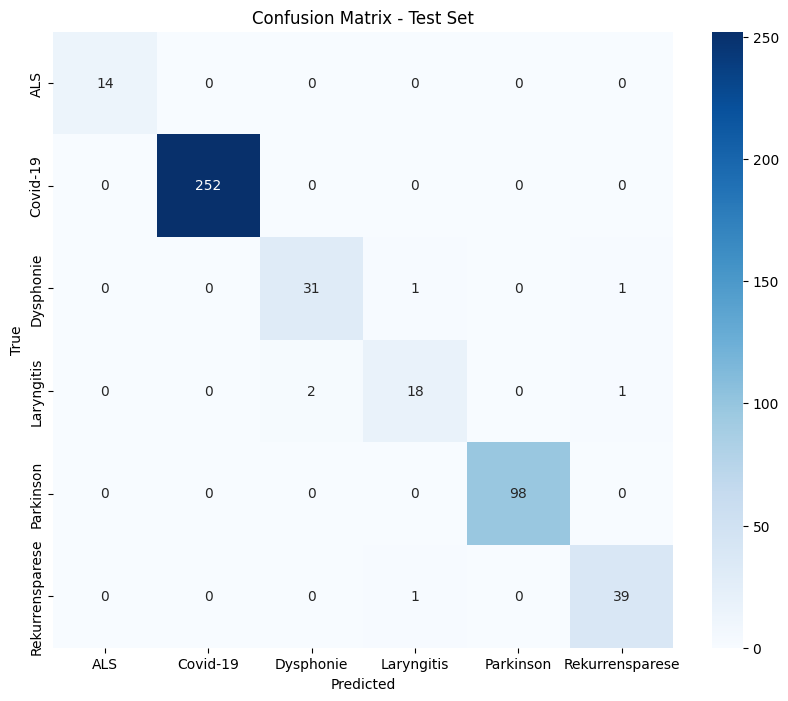

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
## classifier FP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_FP_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_FP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 3424
Filtered testing samples: 394
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


Epoch 1: Train Loss: 0.7106, Validation Loss: 0.7571
Epoch 2: Train Loss: 0.5600, Validation Loss: 0.6788
Epoch 3: Train Loss: 0.3911, Validation Loss: 0.4921
Epoch 4: Train Loss: 0.3774, Validation Loss: 0.4305
Epoch 5: Train Loss: 0.2792, Validation Loss: 0.4273
Epoch 6: Train Loss: 0.1929, Validation Loss: 0.2582
Epoch 7: Train Loss: 0.1659, Validation Loss: 0.1900
Epoch 8: Train Loss: 0.1629, Validation Loss: 0.2055
Epoch 9: Train Loss: 0.1277, Validation Loss: 0.2822
Epoch 10: Train Loss: 0.1051, Validation Loss: 0.2124
Epoch 11: Train Loss: 0.1131, Validation Loss: 0.2297
Epoch 12: Train Loss: 0.0432, Validation Loss: 0.1483
Epoch 13: Train Loss: 0.0826, Validation Loss: 0.1131
Epoch 14: Train Loss: 0.0789, Validation Loss: 0.1805
Epoch 15: Train Loss: 0.0878, Validation Loss: 0.2893
Epoch 16: Train Loss: 0.0629, Validation Loss: 0.1426
Epoch 17: Train Loss: 0.0260, Validation Loss: 0.1408
Epoch 18: Train Loss: 0.0640, Validation Loss: 0.1960
Epoch 19: Train Loss: 0.1044, Validat

In [ ]:
### classifier FP test

<ipython-input-3-193dd2f226d0>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))


Precision: 0.9675
Recall: 0.9645
F1 Score: 0.9650
MCC: 0.9531


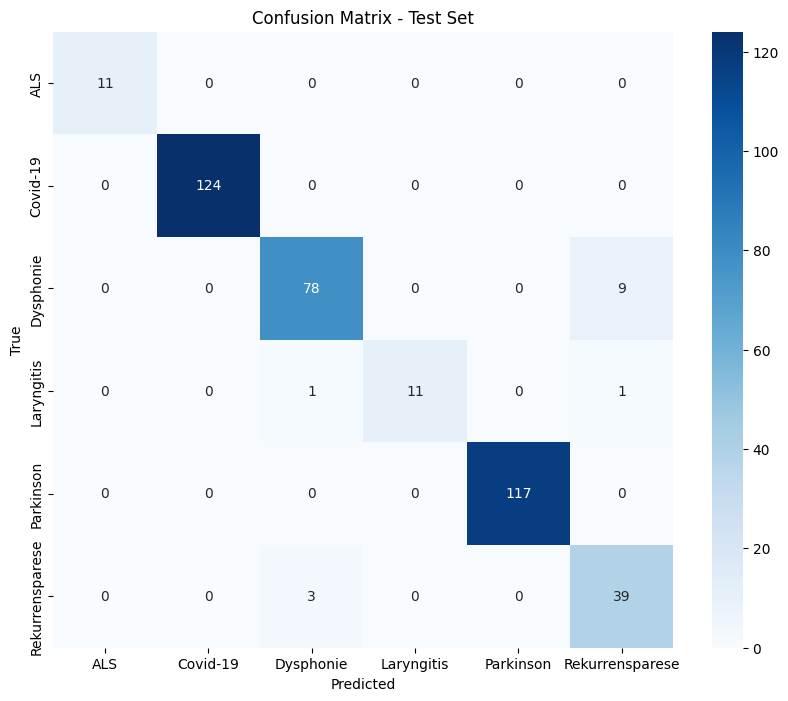

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
### two stage architecture test

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]
<ipython-input-2-c5a47238f324>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Total samples: 2702
Samples classified as HC: 1866
Precision: 0.9581
Recall: 0.9578
F1 Score: 0.9577
MCC: 0.9157


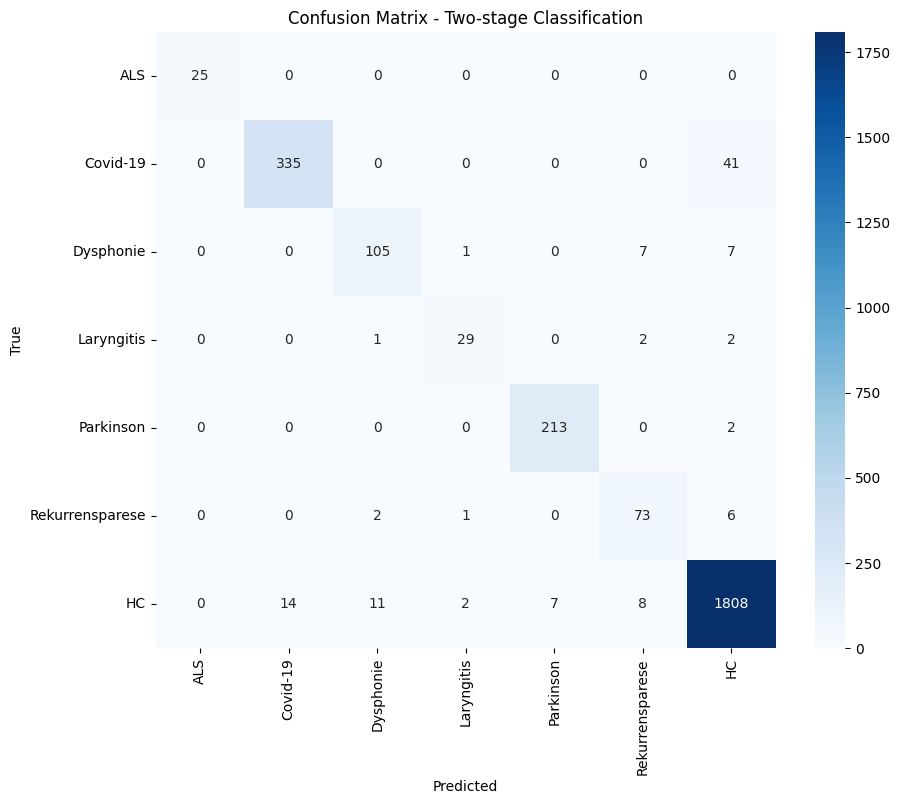

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5: 
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()


In [ ]:
### EXP 3.2 Timewarp based two stage architecture

In [ ]:
### classifier PD training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "MC": 0,  # Male Control
    "MP": 1,  # Male Pathology
    "FC": 2,  # Female Control
    "FP": 3   # Female Pathology
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2:  
            mel = mel.unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=4): 
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1

    last_mcc_values = []  

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        last_mcc = matthews_corrcoef(y_true, y_pred)
        last_mcc_values.append(last_mcc)
        print(f"Fold {fold} | MCC: {last_mcc:.4f}")
        fold += 1

    avg_mcc = np.mean(last_mcc_values)
    print(f"Average MCC for batch_size={batch_size}, lr={lr}: {avg_mcc:.4f}")

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best Parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# retrain on whole training set
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

train_losses = []

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    train_losses.append(avg_train_loss)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

final_model_save_path = os.path.join(output_dir, "final_group_classifier.pth")
torch.save(final_model.state_dict(), final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

final_model.load_state_dict(torch.load(final_model_save_path))
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


Epoch 1: Train Loss: 0.7024, Validation Loss: 0.5668
Epoch 2: Train Loss: 0.4640, Validation Loss: 0.4236
Epoch 3: Train Loss: 0.3321, Validation Loss: 0.3183
Epoch 4: Train Loss: 0.2483, Validation Loss: 0.2111
Epoch 5: Train Loss: 0.1842, Validation Loss: 0.1746
Epoch 6: Train Loss: 0.1486, Validation Loss: 0.1423
Epoch 7: Train Loss: 0.1237, Validation Loss: 0.1536
Epoch 8: Train Loss: 0.0956, Validation Loss: 0.2785
Epoch 9: Train Loss: 0.0950, Validation Loss: 0.1389
Epoch 10: Train Loss: 0.0719, Validation Loss: 0.1640
Epoch 11: Train Loss: 0.0780, Validation Loss: 0.1306
Epoch 12: Train Loss: 0.0494, Validation Loss: 0.1481
Epoch 13: Train Loss: 0.0582, Validation Loss: 0.1215
Epoch 14: Train Loss: 0.0447, Validation Loss: 0.2365
Epoch 15: Train Loss: 0.0598, Validation Loss: 0.0816
Epoch 16: Train Loss: 0.0425, Validation Loss: 0.1142
Epoch 17: Train Loss: 0.0413, Validation Loss: 0.0876
Epoch 18: Train Loss: 0.0387, Validation Loss: 0.1203
Epoch 19: Train Loss: 0.0323, Validat

<ipython-input-2-78d3d808d163>:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(final_model_save_path))


Test Set Results - Fold Final: MCC: 0.9661


In [ ]:
## classifier PD test

<ipython-input-3-99cc715392d4>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))


Precision: 0.9768
Recall: 0.9767
F1 Score: 0.9766
MCC: 0.9661


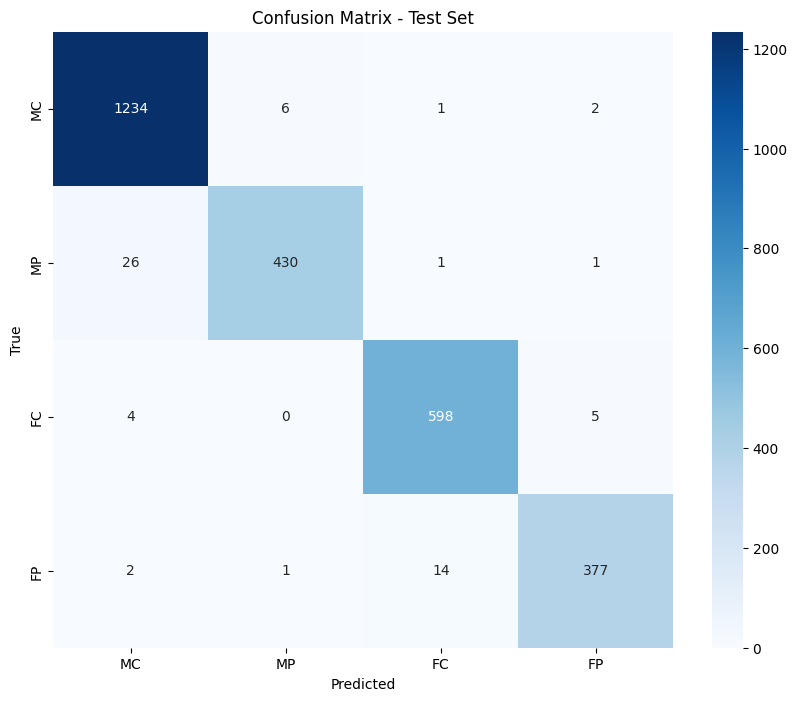

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/final_group_classifier.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)


In [ ]:
### classifier MP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2: 
            mel = mel.unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_MP_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_MP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 5599
Filtered testing samples: 458
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Epoch 1: Train Loss: 0.5925, Validation Loss: 1.1733
Epoch 2: Train Loss: 0.1877, Validation Loss: 0.2715
Epoch 3: Train Loss: 0.1305, Validation Loss: 0.0956
Epoch 4: Train Loss: 0.1045, Validation Loss: 0.3856
Epoch 5: Train Loss: 0.0639, Validation Loss: 0.0945
Epoch 6: Train Loss: 0.0448, Validation Loss: 0.0058
Epoch 7: Train Loss: 0.0103, Validation Loss: 0.0892
Epoch 8: Train Loss: 0.0395, Validation Loss: 0.0848
Epoch 9: Train Loss: 0.0827, Validation Loss: 0.0089
Epoch 10: Train Loss: 0.0244, Validation Loss: 0.1348
Epoch 11: Train Loss: 0.0470, Validation Loss: 0.0177
Epoch 12: Train Loss: 0.0188, Validation Loss: 0.0365
Epoch 13: Train Loss: 0.0127, Validation Loss: 0.0081
Epoch 14: Train Loss: 0.0068, Validation Loss: 0.0067
Epoch 15: Train Loss: 0.0013, Validation Loss: 0.0004
Epoch 16: Train Loss: 0.0004, Validation Loss: 0.0000
Epoch 17: Train Loss: 0.0408, Validation Loss: 0.2514
Epoch 18: Train Loss: 0.0753, Validation Loss: 0.0082
Epoch 19: Train Loss: 0.0474, Validat

In [ ]:
### classifier MP test

<ipython-input-3-5a625e53b0fb>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))


Precision: 0.9871
Recall: 0.9869
F1 Score: 0.9870
MCC: 0.9794


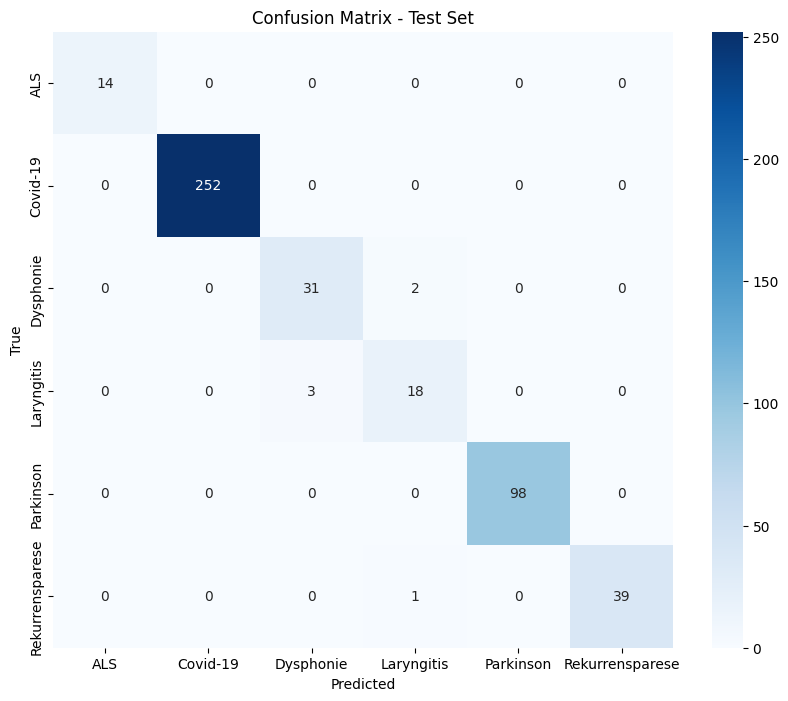

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_MP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
## classifier FP training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/MA'
output_dir = base_path  

# Class Mapping
classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5
}

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32)
        if mel.ndim == 2: 
            mel = mel.unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

train_set_path = os.path.join(base_path, "train_set.xlsx")
test_set_path = os.path.join(base_path, "test_set.xlsx")
train_df = pd.read_excel(train_set_path)
test_df = pd.read_excel(test_set_path)

def evaluate_on_test_set(model, test_loader, fold):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Test Set (Fold {fold})")
    plt.savefig(os.path.join(output_dir, f"test_confusion_FP_matrix_fold_{fold}.png"))
    plt.close()

    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Test Set Results - Fold {fold}: MCC: {mcc:.4f}")
    save_test_metrics(fold, mcc)

batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4, 1e-5]
param_combinations = list(itertools.product(batch_sizes, learning_rates))
print("Hyperparameter combinations:")
for combo in param_combinations:
    print(combo)

best_params = None
best_model = None
best_val_mcc = -1

cv_results = []

# Training
for batch_size, lr in param_combinations:
    print(f"Testing parameter combination: batch_size={batch_size}, lr={lr}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold = 1
    fold_metrics = []

    for train_idx, val_idx in skf.split(train_files, train_labels):
        print(f"Starting Fold {fold} with batch_size={batch_size}, lr={lr}")

        train_dataset = MelDataset([train_files[i] for i in train_idx], [train_labels[i] for i in train_idx])
        val_dataset = MelDataset([train_files[i] for i in val_idx], [train_labels[i] for i in val_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet50Classifier(num_classes=len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = [], []

        for epoch in range(30):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            total_val_loss = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

            train_loss = total_train_loss / len(train_loader)
            val_loss = total_val_loss / len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        mcc = matthews_corrcoef(y_true, y_pred)
        fold_metrics.append(mcc)
        print(f"Fold {fold} | MCC: {mcc:.4f}")
        fold += 1

    avg_mcc = sum(fold_metrics) / len(fold_metrics)
    cv_results.append((batch_size, lr, avg_mcc))

    if avg_mcc > best_val_mcc:
        best_val_mcc = avg_mcc
        best_params = (batch_size, lr)
        best_model = model

print(f"Best parameters: batch_size={best_params[0]}, lr={best_params[1]} with MCC={best_val_mcc:.4f}")

# Retrain on whole training set
print("Retraining model with best parameters on full training set...")
final_train_dataset = MelDataset(train_files, train_labels)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params[0], shuffle=True)
final_model = ResNet50Classifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[1])

for epoch in range(30):
    final_model.train()
    total_train_loss = 0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f"Retrain Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}")

model_save_path = os.path.join(output_dir, "best_resnet50_FP_model.pth")
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Evaluating final model on test set...")
evaluate_on_test_set(final_model, test_loader, "Final")


Using device: cuda
Filtered training samples: 3427
Filtered testing samples: 394
Hyperparameter combinations:
(32, 0.001)
(32, 0.0001)
(32, 1e-05)
(64, 0.001)
(64, 0.0001)
(64, 1e-05)
Testing parameter combination: batch_size=32, lr=0.001
Starting Fold 1 with batch_size=32, lr=0.001


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Epoch 1: Train Loss: 0.6491, Validation Loss: 0.4143
Epoch 2: Train Loss: 0.3344, Validation Loss: 0.4733
Epoch 3: Train Loss: 0.2987, Validation Loss: 0.1837
Epoch 4: Train Loss: 0.1899, Validation Loss: 0.1076
Epoch 5: Train Loss: 0.1305, Validation Loss: 3.0425
Epoch 6: Train Loss: 0.1825, Validation Loss: 2.1072
Epoch 7: Train Loss: 0.1097, Validation Loss: 0.2812
Epoch 8: Train Loss: 0.0922, Validation Loss: 0.1498
Epoch 9: Train Loss: 0.0991, Validation Loss: 0.0673
Epoch 10: Train Loss: 0.1378, Validation Loss: 0.1471
Epoch 11: Train Loss: 0.0420, Validation Loss: 0.0514
Epoch 12: Train Loss: 0.0176, Validation Loss: 0.0252
Epoch 13: Train Loss: 0.0389, Validation Loss: 0.0579
Epoch 14: Train Loss: 0.0143, Validation Loss: 0.0221
Epoch 15: Train Loss: 0.0498, Validation Loss: 0.0493
Epoch 16: Train Loss: 0.0273, Validation Loss: 0.0274
Epoch 17: Train Loss: 0.0196, Validation Loss: 0.0327
Epoch 18: Train Loss: 0.0173, Validation Loss: 0.1119
Epoch 19: Train Loss: 0.0326, Validat

In [ ]:
### classifier FP test

<ipython-input-4-193dd2f226d0>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))


Precision: 0.9755
Recall: 0.9746
F1 Score: 0.9747
MCC: 0.9662


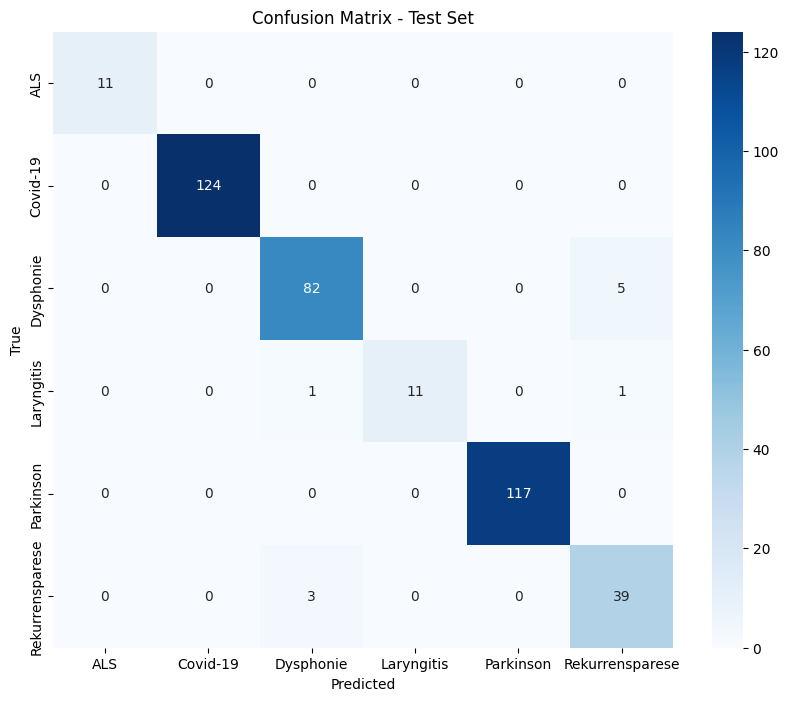

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes.keys(), yticklabels=classes.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return precision, recall, f1, mcc

final_model.load_state_dict(torch.load('/content/MA/best_resnet50_FP_model.pth'))
final_model.to(device)

precision, recall, f1, mcc = evaluate_model_on_test_set(final_model, test_loader)

In [ ]:
### two stage architecture test

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]
<ipython-input-2-c5a47238f324>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Total samples: 2702
Samples classified as HC: 1880
Precision: 0.9762
Recall: 0.9763
F1 Score: 0.9761
MCC: 0.9525


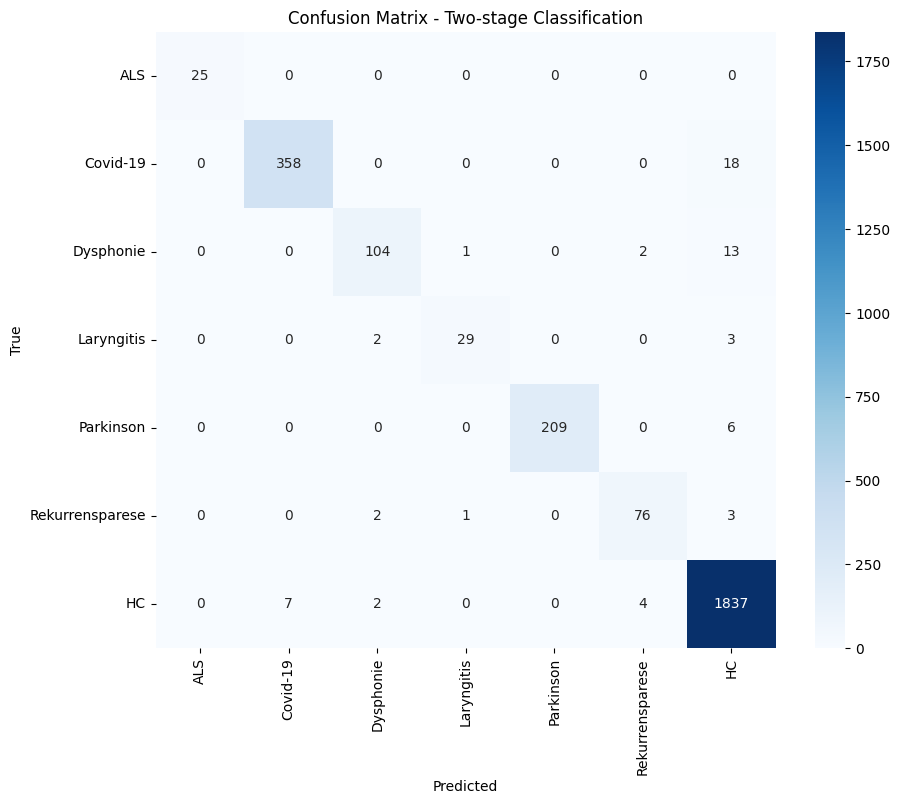

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5: 
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()
